# CS 429: Information Retrieval
<br>

## Clustering Words

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology
### Spring 2015

# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [69]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
                 os.environ.get('TW_CONSUMER_SECRET'),
                 os.environ.get('TW_ACCESS_TOKEN'),
                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))

# Collect 5000 tweets.
tweets = []
while True: 
    r = api.request('statuses/filter', {'track':'i',
                                      'language':'en'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)
            if len(tweets) > 5000:
                break
            elif len(tweets) % 100 == 0:
                print(len(tweets))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000


In [70]:
print(len(tweets))

5002


In [71]:
# Each tweet is a Python dict.
print('text', tweets[0]['text'])
print('description:', tweets[0]['user']['description'])
print('name:', tweets[0]['user']['name'])
print('location:', tweets[0]['user']['location'])

text I just love white women
description: fightin games ||
Master Tier Support LFT
name: Aaron Chestnut
location: None


In [75]:
tweets2 = [t for t in tweets if 'text' in t]

In [76]:
len(tweets2)

4620

In [77]:
tweets = tweets2

In [78]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
tokens[0]

['i', 'just', 'love', 'white', 'women']

In [79]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [80]:
# Inspect word counts.
import math

print(len(word_counts), 'unique terms')
word_counts.most_common(10)

7328 unique terms


[('i', 5693),
 ('rt', 1949),
 ('to', 1389),
 ('the', 1288),
 ('a', 1267),
 ('you', 1263),
 ('my', 914),
 ('m', 866),
 ('and', 847),
 ('it', 729)]

In [81]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.items() if c > 1])
print('%d words occur at least two times.' % len(vocab))

3036 words occur at least two times.


In [82]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks

In [85]:
# A sample pruned tweet.
tokens[2]

['rt',
 'i',
 'didn',
 't',
 'like',
 'this',
 'song',
 'but',
 'then',
 'i',
 'heard',
 'the',
 'acoustic',
 'one',
 'enjoy',
 'ht',
 'secondcover',
 'is',
 'back']

In [86]:
# For each term, create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = []
        for j in range(np.amax([0, i-window]), i):
            features.append(tweet[j] + "@" + str(j-i))
        for j in range(i+1, min(i + window, len(tweet))):
            features.append(tweet[j] + "@" + str(j-i))
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])


In [87]:
contexts['i'].most_common(20)

[('m@1', 856),
 ('rt@-1', 812),
 ('love@1', 308),
 ('and@-1', 213),
 ('don@1', 211),
 ('rt@-2', 190),
 ('have@1', 175),
 ('ve@1', 173),
 ('just@1', 172),
 ('ll@1', 168),
 ('can@1', 162),
 ('i@-2', 154),
 ('but@-1', 141),
 ('am@1', 133),
 ('was@1', 133),
 ('want@1', 129),
 ('need@1', 119),
 ('when@-1', 105),
 ('the@-2', 104),
 ('me@-2', 102)]

In [88]:
# Compute the number of different contexts each term appears in.
tweet_freq = Counter()
for context in contexts.values():
    tweet_freq.update(context)
tweet_freq.most_common(5)

[('i@-1', 5660),
 ('i@-2', 5465),
 ('i@1', 4417),
 ('rt@-1', 1946),
 ('rt@-2', 1936)]

In [89]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.items():
    for term2, frequency in context.items():
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.values()]))
    for term2, frequency in context.items():
        context[term2] = 1. * frequency / length
    
contexts['i'].most_common(5)

[('m@1', 0.5656589180724478),
 ('rt@-1', 0.4859104689814621),
 ('love@1', 0.2202735016170549),
 ('don@1', 0.16001560906605292),
 ('ve@1', 0.14220010056448193)]

In [90]:
contexts['school'].most_common(10)

[('high@-1', 0.5400194871529245),
 ('route@-2', 0.30582161043598705),
 ('cares@-2', 0.23439654109318486),
 ('to@-1', 0.22331684789196019),
 ('smiles@-2', 0.18062316964958),
 ('middle@-1', 0.18062316964958),
 ('and@1', 0.15842753516603655),
 ('children@-2', 0.14572563597732363),
 ('lessons@1', 0.14572563597732363),
 ('doesn@1', 0.14005078764583445)]

At this point we have a list of dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [31]:
# This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    for k in keys:
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print(distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4}))
print(distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4}))

1.4142135623730951
2.23606797749979


In [45]:
def find_closest(term, n=5):
    terms = np.array(list(contexts.keys()))
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.items():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n]

find_closest('love', n=10)

array(['love', 'phottto', 'm', 'wuv', 'hope', 'miss', 'hate', 'am', 've',
       'need'], 
      dtype='<U31')

In [46]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print(len(nz_contexts), 'nonzero contexts')

6498 nonzero contexts


In [47]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print(names[:10])
print(X[0])

['a@-1' 'a@-2' 'a@1' 'aa@1' 'aaaaa@-1' 'aaaaa@-2' 'aaaaaaa@1' 'aap@-1'
 'aap@-2' 'aap@1']
  (0, 2274)	0.6176837477
  (0, 7638)	0.179774039551
  (0, 13465)	0.765603084196


In [49]:
names[13465]

'san@-1'

In [50]:
# Let's cluster!
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=20, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [52]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print(i, ' '.join(names[np.argsort(kmeans.cluster_centers_[i])[::-1][:5]]))

0 to@-2 be@-1 get@-1 on@1 i@1
1 to@1 i@-2 i@-1 m@-1 m@-2
2 my@-1 in@-2 on@-2 i@1 and@1
3 so@-2 many@-1 i@-1 much@-1 and@1
4 me@1 you@-1 i@-2 to@-1 just@-1
5 on@-1 t@-1 in@-2 can@-2 don@-2
6 the@-1 in@-2 i@1 of@1 to@-2
7 in@-1 i@1 north@1 m@-2 people@-2
8 to@-1 want@-2 i@-1 i@-2 the@1
9 a@-2 the@-2 of@1 i@1 same@-1
10 i@1 rt@-1 rt@-2 so@-1 i@-2
11 i@-1 rt@-2 t@1 i@-2 you@1
12 and@1 you@-2 with@-1 i@-2 be@-1
13 that@-1 thought@-2 let@-2 in@1 a@-1
14 i@-2 m@-1 just@-1 love@-1 a@1
15 a@-1 of@1 have@-2 i@1 in@-2
16 in@1 the@-1 i@-2 have@-2 and@-2
17 was@-1 i@-2 for@1 it@-2 in@1
18 rt@-1 i@-2 i@1 m@-2 i@-1
19 that@-2 s@-1 was@-1 on@1 are@-1


In [54]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
distances[0]

array([ 1.06722165,  1.10782027,  1.0674842 ,  1.18638417,  1.08373736,
        0.99943939,  1.09045508,  1.0457564 ,  1.06041701,  1.01911992,
        1.05633428,  1.10211629,  1.05770685,  1.07120721,  1.07142553,
        1.06685455,  1.06787381,  1.19213258,  1.00018739,  1.1250639 ])

In [56]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(list(contexts.keys()))
for i in range(num_clusters):
    print(i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n')

0 shorter mall cait separated bands mosque bough concerned downnnn 

1 beed refuse loyal yg needless movin aspire sea want 

2 life losses favs grandma bestfriend defense undies ringtone lurking 

3 pus deleated bbloggers dogs options muchh chains spared pushed 

4 annoy tickle bugs push replace interrupt texted trills told 

5 apocalyptic deal snapchat deny kik stress wait replace netflix 

6 jansport mall truth same sea gutter summertime mosque bands 

7 uk tht constantly peterhof causing lmm looovee rehearsals russia 

8 retur be carpool recap create throw netball surprise get 

9 thing victory mores playroom supporter of autchat from thicker 

10 when ahhhhh confidently meanwhile hola kubsnjidirect produce justtwitterthings hahah 

11 am hope love ve swear ll need hate think 

12 siyeon lonely lurking kalie groomers panics gray mommy deleated 

13 hole negativity matters input promotion sink slide nigga reminds 

14 gatvol starving sighs yelling weak torn imagining babysitting emba

Clearly, interpreting these results requires a bit of investigation.

Some patterns do emerge:
 - Cluster 7 has Polish
 - Cluster 8 are about communication acts
 - Cluster 13 is family
 - Cluster 14 seems to be abbreviations/[disfluencies](http://en.wikipedia.org/wiki/Speech_disfluency)

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [121]:
print kmeans.score(X)

-7445.99342108


k=5 score=-7797.96
k=10 score=-7713.23
k=20 score=-7583.07
k=50 score=-7472.8
k=100 score=-7311.88


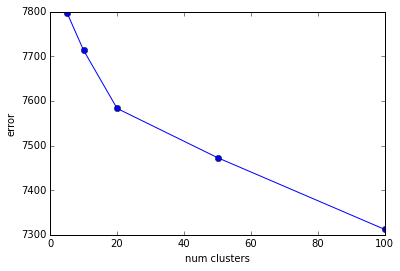

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print 'k=%d score=%g' % (num_clusters, score)
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=7500.51
score=7487.98
score=7492.89
score=7476.02
score=7468.77
score=7493.28
score=7486.01
score=7519.28
score=7488.46
score=7525.88


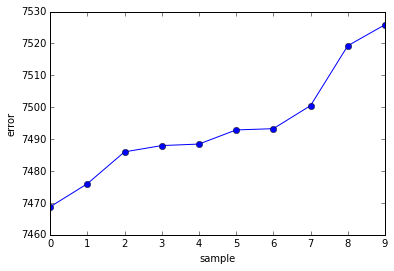

In [92]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1, max_iter=100, init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print 'score=%g' % (score)
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()